###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):** 1212439, 1209191


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [60]:
#Importing the required libraries
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from collections import Counter

In [56]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(csv_name):
    #Reading in the data and dropping 'filename' column
    data = pd.read_csv(csv_name)
    data = data.drop(["filename"], axis = 1)
    return data

In [35]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data):
    #Reading the 'labels' column and calculating prior probabilities for all classes
    n = len(data)
    prior_prob = []
    labels = data.values[:,-1]
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    for i in range(len(unique_labels)):
        prior_prob.insert(i, (counts[i] / n).round(2))
    
    unique_labels = np.unique(data.values[:,-1])
    unique_labels = list(unique_labels)
    
    #Creating a list of features to iterate over
    features_list = list(data.columns)
    features_list.remove('label')
    
    #Creating a multi-dimensional list to store parameters (mean and variance) for all features
    mean = [ [] for i in range(len(unique_labels)) ]
    variance = [ [] for i in range(len(unique_labels)) ]
    
    #Iterating over features and labels to calculate mean and variance 
    for feature in features_list:
        for label in unique_labels:
            feature_values = data[feature].loc[data['label'] == label]
            mean[unique_labels.index(label)].insert(features_list.index(feature), np.mean(feature_values))
            variance[unique_labels.index(label)].insert(features_list.index(feature), np.var(feature_values))
    
    #Combining both mean and variance lists to store in one array for easy access
    mean_var = []
    for i in range(len(mean)):
        mean_row = mean[i]
        var_row = variance[i]
        for n, value in enumerate(mean_row):
            mean_val = value
            var_val = var_row[n]
            mean_var.append([mean_val, var_val])
    
    #Splitting array into multiple sub-arrays according to the number of classes
    mean_var = np.array(mean_var)   
    mean_var = np.vsplit(mean_var, len(unique_labels))
    
    return unique_labels, prior_prob, mean_var

In [36]:
def predict(test_data, labels, priors, parameters):
    test_data = test_data.drop(['label'], axis=1)
    
    #Defining the probability density function of the normal distribution
    def normal_dist(x, mean, var):
        exponent = math.exp(-((x - mean) ** 2 / (2 * var)))
        return (1 / (math.sqrt(2 * math.pi) * math.sqrt(var))) * exponent
    
    #Setting a value for the smoothing parameter
    epsilon = 0.001
    
    #Iterating over rows of the test data
    predicted_labels = []
    for index, instance in test_data.iterrows():
        instance = list(instance[:-1])
        class_probabilities = []
        for i in range(len(labels)):
            probabilities = []
            for n in range(len(instance)):
                #Calculating conditional probability
                prob = normal_dist(instance[n], parameters[i][n][0], parameters[i][n][1])
                #Going to the next iteration (next feature) if the attribute value is missing
                if math.isnan(instance[n]) == True:
                    continue            
                #Smoothing to avoid log errors
                if prob == 0:
                    prob = epsilon
                probabilities.insert(n, np.log(prob))
            probability = sum(probabilities)
            #Calculating posterior probability
            probability = np.log(priors[i]) + probability
            class_probabilities.insert(i, probability)
        
        #Choosing the predicted label based on the higher posterior probability
        predicted_labels.insert(index, labels[class_probabilities.index(max(class_probabilities))])

    return predicted_labels


In [52]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(predicted_labels, test_data, positive_class):
    truth_labels = list(test_data.values[:,-1])
    
    #Calculating metrics for binary classification problems
    if positive_class is not None: 
        sk_accuracy = accuracy_score(truth_labels, predicted_labels)
        print('Accuracy: {}.'.format(sk_accuracy))
        sk_report = classification_report(truth_labels, predicted_labels)
        conf_matrix = confusion_matrix(truth_labels, predicted_labels)
        print('Classification report:')
        print(sk_report)
        print('Confusion matrix:')
        print(conf_matrix)

    #Calculating metrics for multiclass classification problems
    else:
        sk_accuracy = accuracy_score(truth_labels, predicted_labels)
        print('Average accuracy: {}.'.format(sk_accuracy))
        sk_report = classification_report(truth_labels, predicted_labels, zero_division = 0)
        conf_matrix = confusion_matrix(truth_labels, predicted_labels)
        print('Classification report:')
        print(sk_report)
        print('Confusion matrix:')
        print(conf_matrix)
    
    return 

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [57]:
labels, priors, parameters = train(preprocess("pop_vs_classical_train.csv"))
predicted_labels = predict(preprocess("pop_vs_classical_test.csv"), labels, priors, parameters)
evaluate(predicted_labels, preprocess("pop_vs_classical_test.csv"), "classical")

Accuracy: 0.9767441860465116.
Classification report:
              precision    recall  f1-score   support

   classical       0.95      1.00      0.98        20
         pop       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43

Confusion matrix:
[[20  0]
 [ 1 22]]


### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

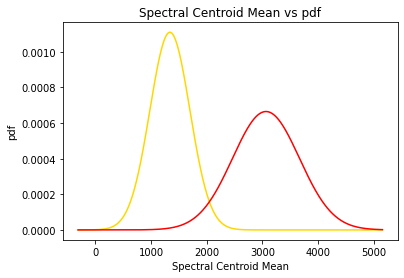

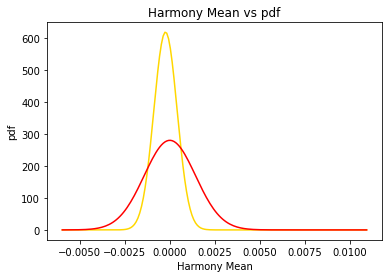

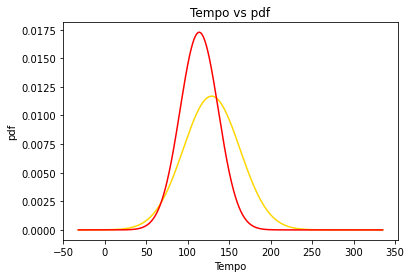

In [61]:
data = preprocess("pop_vs_classical_train.csv")
features_list = list(data.columns)
features_list.remove('label')

labels, priors, mean_var = train(data)
select_meanvar = []

#Extracting parameters from parameter list
for i in range(len(features_list)):
    if features_list[i] in {'spectral_centroid_mean', 'harmony_mean', 'tempo'}:
        select_meanvar.append([features_list[i], mean_var[0][i][0], math.sqrt(mean_var[0][i][1]), mean_var[1][i][0], math.sqrt(mean_var[1][i][1])])

#Plot for spectral_centroid_mean
x = np.arange(min(data['spectral_centroid_mean'])-1000, max(data['spectral_centroid_mean'])+1000, 0.001)
plt.plot(x, norm.pdf(x, select_meanvar[0][1], select_meanvar[0][2]), label='spectral_centroid_mean, classical', color='gold')
plt.plot(x, norm.pdf(x, select_meanvar[0][3], select_meanvar[0][4]), label='spectral_centroid_mean, pop', color='red')
plt.title("Spectral Centroid Mean vs pdf")
plt.xlabel("Spectral Centroid Mean")
plt.ylabel("pdf")
plt.show()

#Plot for harmony_mean
y = np.arange(min(data['harmony_mean'])-0.002, max(data['harmony_mean']), 0.0001)
plt.plot(y, norm.pdf(y, select_meanvar[1][1], select_meanvar[1][2]), label='harmony_mean, classical', color='gold')
plt.plot(y, norm.pdf(y, select_meanvar[1][3], select_meanvar[1][4]), label='harmony_mean, pop', color='red')
plt.title("Harmony Mean vs pdf")
plt.xlabel("Harmony Mean")
plt.ylabel("pdf")
plt.show()

#Plot for tempo
z = np.arange(min(data['tempo'])-100, max(data['tempo'])+100, 0.001)
plt.plot(z, norm.pdf(z, select_meanvar[2][1], select_meanvar[2][2]), label='tempo, classical', color='gold')
plt.plot(z, norm.pdf(z, select_meanvar[2][3], select_meanvar[2][4]), label='tempo, pop', color='red')
plt.title("Tempo vs pdf")
plt.xlabel("Tempo")
plt.ylabel("pdf")
plt.show()

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [62]:
#Implementing model with gztan dataset

gztan_labels, gztan_priors, gztan_parameters = train(preprocess("gztan_train.csv"))
gztan_predicted_labels = predict(preprocess("gztan_test.csv"), gztan_labels, gztan_priors, gztan_parameters)
gztan_metrics = evaluate(gztan_predicted_labels, preprocess("gztan_test.csv"), positive_class = None)

Average accuracy: 0.49.
Classification report:
              precision    recall  f1-score   support

       blues       0.50      0.21      0.30        19
   classical       0.89      0.85      0.87        20
     country       0.39      0.69      0.50        16
       disco       0.43      0.41      0.42        22
      hiphop       0.46      0.29      0.35        21
        jazz       0.50      0.33      0.40        18
       metal       0.37      0.90      0.52        20
         pop       0.80      0.70      0.74        23
      reggae       0.53      0.57      0.55        14
        rock       0.20      0.11      0.14        27

    accuracy                           0.49       200
   macro avg       0.51      0.51      0.48       200
weighted avg       0.50      0.49      0.47       200

Confusion matrix:
[[ 4  0  5  0  0  1  7  0  2  0]
 [ 0 17  0  0  0  1  0  0  0  2]
 [ 0  0 11  2  1  0  2  0  0  0]
 [ 1  0  0  9  3  1  5  0  1  2]
 [ 0  0  1  2  6  0  5  3  2  2]
 [ 1  1  2 

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

In [63]:
train_data = preprocess("gztan_train.csv")
test_data = preprocess("gztan_test.csv")
test_labels = test_data.values[:,-1]
train_labels = train_data.label

#0R baseline using dummy classifier
most_frq_clf = DummyClassifier(strategy='most_frequent')
most_frq_clf.fit(train_data, train_labels)
accuracies = []
num_runs = 30
for i in range(num_runs):
    acc = most_frq_clf.score(test_data, truth_labels)
    accuracies.append(acc)
print('Average accuracy over {} runs is: {}.'.format(num_runs, np.mean(accuracies)))

#One attribute baseline using train() and predict()
for x in train_data.columns[:-1]:
    train_data_x = train_data[[x, 'label']]
    test_data_x = test_data[[x, 'label']]
    oner_labels, oner_priors, oner_parameters = train(train_data_x)
    predicted_labels = predict(test_data_x, oner_labels, oner_priors, oner_parameters)
    acc = accuracy_score(test_labels, predicted_labels)
    print('Accuracy for {} is: {}.'.format(x, acc))

Average accuracy over 30 runs is: 0.07.
Accuracy for chroma_stft_mean is: 0.07.
Accuracy for chroma_stft_var is: 0.07.
Accuracy for rms_mean is: 0.07.
Accuracy for rms_var is: 0.07.
Accuracy for spectral_centroid_mean is: 0.07.
Accuracy for spectral_centroid_var is: 0.07.
Accuracy for spectral_bandwidth_mean is: 0.07.
Accuracy for spectral_bandwidth_var is: 0.07.
Accuracy for rolloff_mean is: 0.07.
Accuracy for rolloff_var is: 0.07.
Accuracy for zero_crossing_rate_mean is: 0.07.
Accuracy for zero_crossing_rate_var is: 0.07.
Accuracy for harmony_mean is: 0.07.
Accuracy for harmony_var is: 0.07.
Accuracy for perceptr_mean is: 0.07.
Accuracy for perceptr_var is: 0.07.
Accuracy for tempo is: 0.07.
Accuracy for mfcc1_mean is: 0.07.
Accuracy for mfcc1_var is: 0.07.
Accuracy for mfcc2_mean is: 0.07.
Accuracy for mfcc2_var is: 0.07.
Accuracy for mfcc3_mean is: 0.07.
Accuracy for mfcc3_var is: 0.07.
Accuracy for mfcc4_mean is: 0.07.
Accuracy for mfcc4_var is: 0.07.
Accuracy for mfcc5_mean is: 0

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

In [49]:
#Defining a function that takes a dataset and a list of k values (k = number of folds) to set up in each split 
def cross_validate(k_vector, data):
    mean_accuracies = []
    
    for k in k_vector:
        accuracies = []
        kfold = KFold(k, shuffle = True, random_state = 1)
        for train_index, test_index in kfold.split(data):
            x_train = data.iloc[train_index, :]    
            x_test = data.iloc[test_index, :]
            test_truth = x_test.values[:,-1]
            x_labels, x_priors, x_parameters = train(x_train)
            xtest_predicted_labels = predict(x_test, x_labels, x_priors, x_parameters)
            accuracies.append(accuracy_score(xtest_predicted_labels, test_truth))
        
        mean_accuracies.append(np.mean(accuracies))
               
    return mean_accuracies


#Combining the test and train dataset and shuffling it
test_data = preprocess("gztan_test.csv")
train_data = preprocess("gztan_train.csv")
k_data = test_data.append(train_data)
k_data = k_data.sample(frac=1).reset_index(drop=True)


#Defining values for k (number of folds)
k_values = [5, 10, 20, 50]


# Setting number of times we run the cross_validate function and calculating the mean accuracies for each value of k of over number of runs 

num_runs = 1
sum_accuracy = [0 for k in k_values]
for i in range(num_runs):
    accuracies = cross_validate(k_values, k_data)
    for k in k_values:
        sum_accuracy[k_values.index(k)] += accuracies[k_values.index(k)]

avg_accuracy = [sum_acc/num_runs for sum_acc in sum_accuracy]

print('Number of runs: {}'.format(num_runs))
for n, acc in enumerate(avg_accuracy):
    print('Average accuracy for k = {}: {}'.format(k_values[n], acc))


Number of runs: 1
Average accuracy for k = 5: 0.532
Average accuracy for k = 10: 0.5269999999999999
Average accuracy for k = 20: 0.524
Average accuracy for k = 50: 0.527


### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

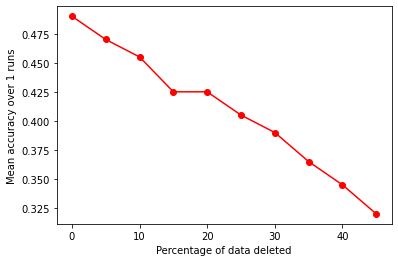

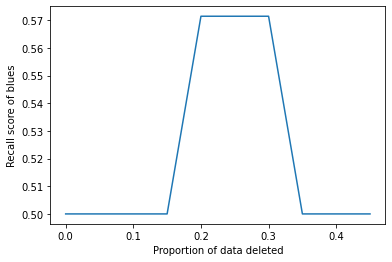

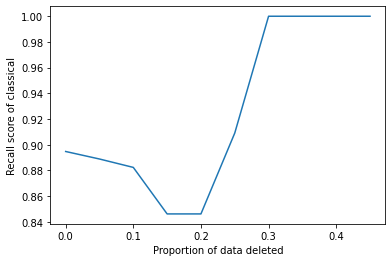

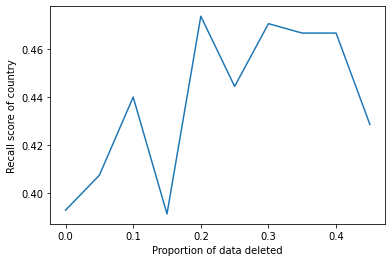

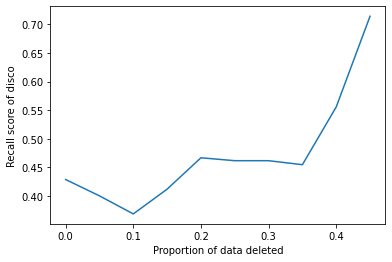

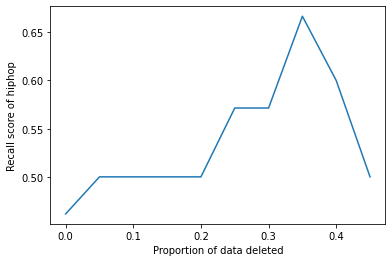

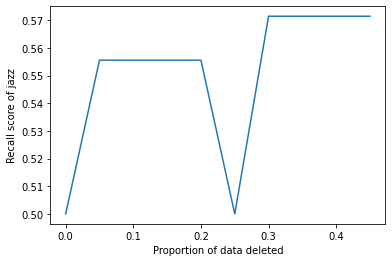

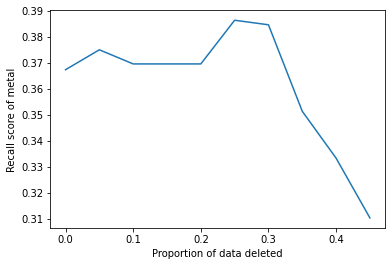

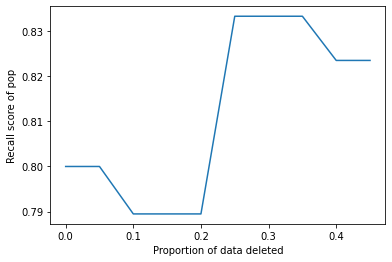

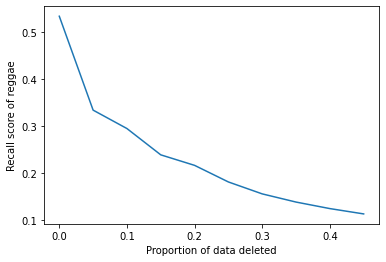

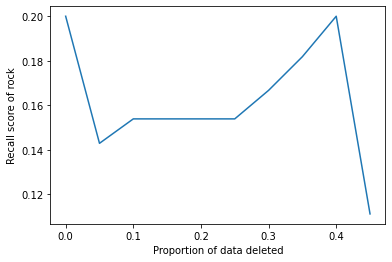

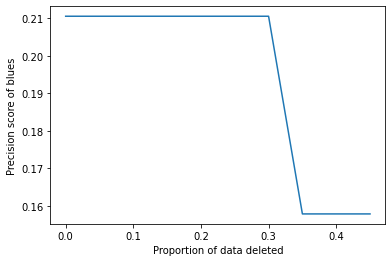

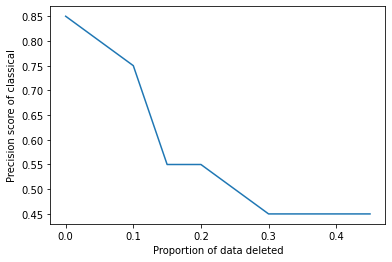

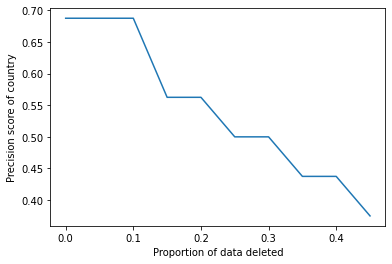

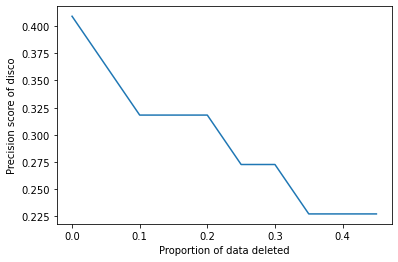

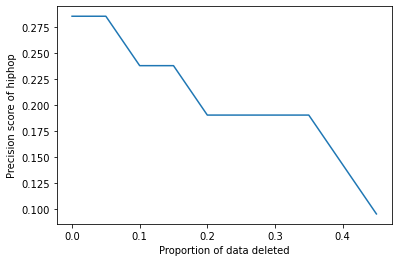

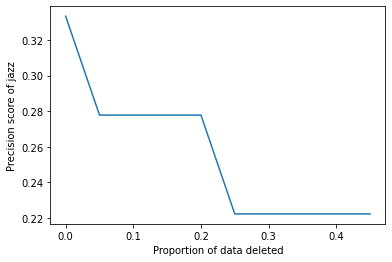

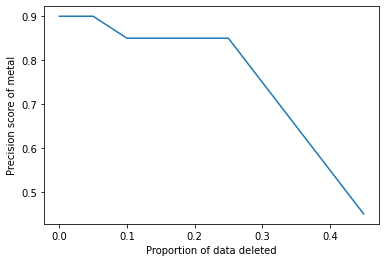

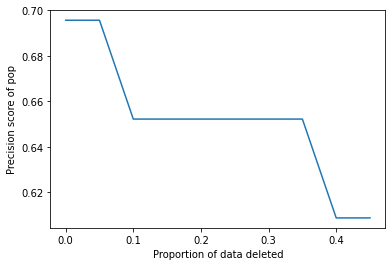

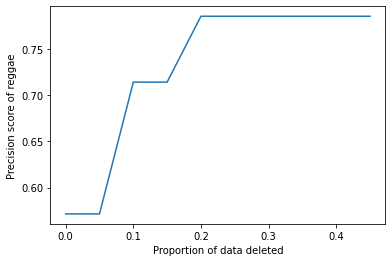

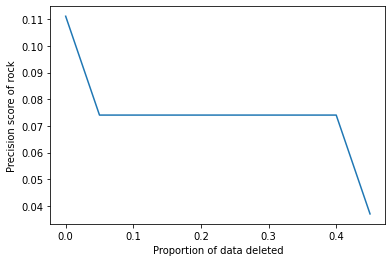

In [59]:
labels, priors, parameters = train(preprocess("gztan_train.csv"))
test_data = preprocess("gztan_test.csv")
truth_labels = list(test_data.values[:,-1])

p = list(np.arange(0, 0.5, 0.05))
accuracy_scores = [ [] for proportion in p]
recall_scores = []
precision_scores = []
 
num_runs = 1
for proportion in p:
    for i in range(num_runs):
        for col in test_data.columns:
            test_data.loc[test_data.sample(frac = proportion, random_state=1).index, col] = np.nan
        
        gztan_predicted_labels_missing = predict(test_data, labels, priors, parameters)
        accuracy_scores[p.index(proportion)].append(accuracy_score(gztan_predicted_labels_missing, truth_labels))
        test_data = preprocess("gztan_test.csv")
        recall_scores.append(recall_score(gztan_predicted_labels_missing, truth_labels, zero_division = 0, average = None))
        precision_scores.append(precision_score(gztan_predicted_labels_missing, truth_labels, zero_division = 0, average = None))
    

mean_scores = [np.mean(score_list) for score_list in accuracy_scores]

#Plots for accuracy as no. of data deleted increases
percentages = [proportion*100 for proportion in p]
plt.plot(percentages, mean_scores, 'ro-')
plt.xlabel('Percentage of data deleted')
plt.ylabel('Mean accuracy over {} runs'.format(num_runs))
plt.show()
    
    
#Printing plots for recall scores - can only be done when num_runs is set to 1
label_list = np.unique(truth_labels)
recall_label_scores = [[] for n in range(len(label_list))]

for score_list in recall_scores:
    for n in range(len(label_list)):
        recall_label_scores[n].append(score_list[n])
        

for score_list in recall_label_scores:
    plt.plot(p, score_list)
    plt.xlabel('Proportion of data deleted')
    plt.ylabel('Recall score of {}'.format(label_list[recall_label_scores.index(score_list)]))
    plt.show()
    
    
#Printing plots for precision scores - can only be done when num_runs is set to 1
label_list = np.unique(truth_labels)
precision_label_scores = [[] for n in range(len(label_list))]

for score_list in precision_scores:
    for n in range(len(label_list)):
        precision_label_scores[n].append(score_list[n])
        

for score_list in precision_label_scores:
    plt.plot(p, score_list)
    plt.xlabel('Proportion of data deleted')
    plt.ylabel('Precision score of {}'.format(label_list[precision_label_scores.index(score_list)]))
    plt.show()
    
    